# AquaGaurd - Code to save water

# Imported libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             roc_auc_score, RocCurveDisplay)


# Problem Statement

A water leak requires a lot of time to identify and fix.


1. Why water leaks matter

   Water leakage is a major cause of global resource scarcity and environmental degradation. In the United States, households waste about 1 trillion gallons annually due to minor leaks. Roughly 13% of all U.S. electricity is used just to pump and treat water, so every leak directly inflates humanity's carbon footprint. When pipes leak, they also lose pressure, which allows bacteria and pollutants to seep into the clean water.



2. Why smart cities need detection

    Modern cities need automatic monitoring to stop reacting to emergencies and start managing resources effectively. Manual inspections are too slow and expensive to cover vast underground networks; in contrast, AI-driven tools can detect subtle changes in water pressure and sound that indicate a leak long before it's visible. By using these digital sensors, cities can fix the most urgent issues first. For example, Copenhagen reduced its emergency response times by 50%, preventing major pipe bursts and saving millions in repair costs.

3. Why synthetic dataset still useful

   Building an app to detect leaks is hard because real-world leak data is scarce and hard to obtain from water companies. Because waiting for physical infrastructure failures to gather data is impractical, Synthetic datasets act like a simulator for algorithm development. These datasets generate diverse, realistic scenarios to train your app’s brain. This ensures your software is tested against thousands of scenarios it might not encounter in the real world, making the final product much more reliable.

# Load and Inspect Data

### Data table

In [2]:

# Load dataset
df = pd.read_csv("WaterLeak.csv")


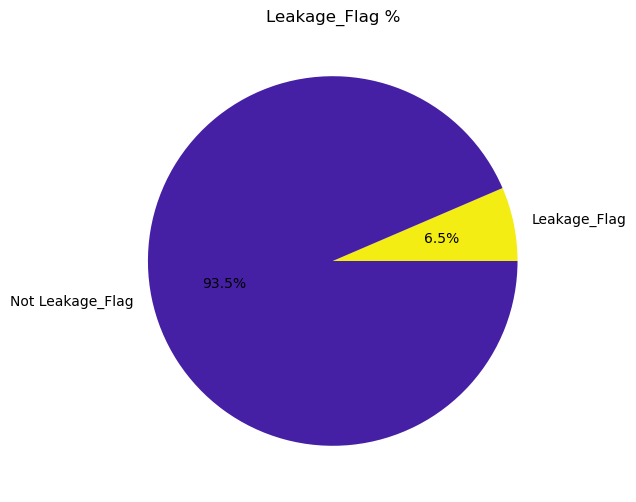

In [3]:
l = list(df['Leakage_Flag'].value_counts())
circle = [l[1] / sum(l) * 100, l[0] / sum(l) * 100]
colors = ['#F3ED13','#451FA4']
# --- Graph 1: Pie Chart ---
plt.figure(figsize=(8, 6))
plt.pie(circle, labels=['Leakage_Flag', 'Not Leakage_Flag'], autopct='%1.1f%%', colors=colors)
plt.title('Leakage_Flag %')
plt.show()

C:\Users\yusha\AppData\Local\Temp\ipykernel_6724\55703329.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Leakage_Flag', data=df, palette=colors)


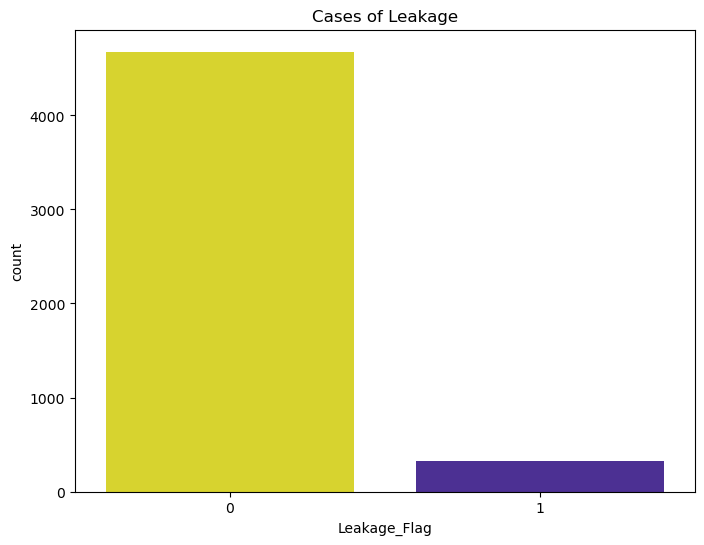

In [4]:

plt.figure(figsize=(8, 6))
sns.countplot(x='Leakage_Flag', data=df, palette=colors)
plt.title('Cases of Leakage')
plt.show()


### Analysis

1. Are there missing values?

    No. The count for every single variable is exactly 5000. Since the count is consistent across all features, shows high integrity with zero null values. 


2. Is Leakage_Flag balanced?

    No, it is highly imbalanced as the leaks are about 6.5%, while the rest of the 93.5% are working normally


3. Are Leaks common and realistic in the dataset?

    No, as observation is this dataset has only a 6.5% leakage rate. In water infrastructure, this is realistic, and leaks are rare events compared to normal operations.

# Categorical Feature Selection


## Chi Square test

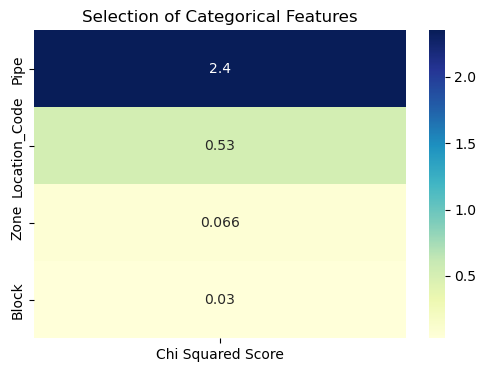

In [5]:
df_cat = df.copy()
le = LabelEncoder()
cat_cols = ['Zone', 'Block', 'Pipe', 'Location_Code']
for col in cat_cols:
    df_cat[col] = le.fit_transform(df_cat[col])

X_fs = df_cat[cat_cols]
y_fs = df_cat['Leakage_Flag']
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(X_fs, y_fs)
featureScores = pd.DataFrame(data=fit.scores_, index=list(X_fs.columns), columns=['Chi Squared Score'])

plt.figure(figsize=(6, 4))
sns.heatmap(featureScores.sort_values(by='Chi Squared Score', ascending=False), annot=True, cmap='YlGnBu')
plt.title('Selection of Categorical Features')
plt.show()

Chi-square is a categorical variable test that helps identify independent variables to include in regression models, improving the overall strength and efficiency of the model and its outcomes. As the chi score increases, it correlates with importance (the higher, the more important). The values prioritized by this square in this dataset are block, zone, location_code, and pipe. Pipe has the highest Chi score out of the categorical variables meaning it is the most important one there for effective modeling.

## Anova test

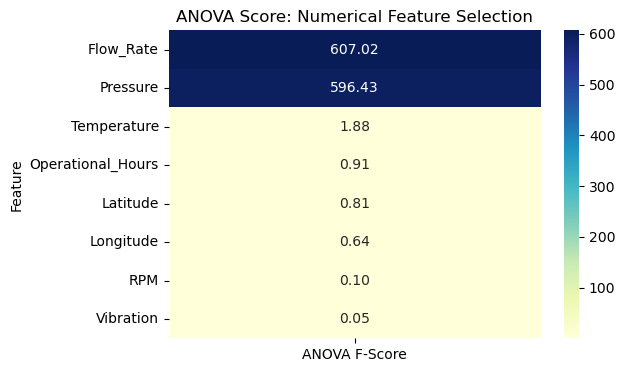

In [6]:
from sklearn.feature_selection import f_classif

# give numerical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Leakage_Flag'], errors='ignore')

#  Run anova through f_classif
f_values, p_values = f_classif(df[num_cols], df['Leakage_Flag'])

anova_scores = pd.DataFrame({'Feature': num_cols, 'ANOVA F-Score': f_values}).set_index('Feature')

# show graph
plt.figure(figsize=(6, 4))
sns.heatmap(anova_scores.sort_values(by='ANOVA F-Score', ascending=False), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('ANOVA Score: Numerical Feature Selection')
plt.show()

The ANOVA (Analysis of Variance) test is a test for continuous variables used to determine whether there are significant differences between group means. It helps identify which numerical data, such as pressure or flow rate, changes when a leak occurs, allowing you to filter out unnecessary data and keep only the most useful variable for the model. The higher the score, the more important the variables are, so Pressure and Temperature are the most impactful. 

# Visual Analysis

### Data distribution plots

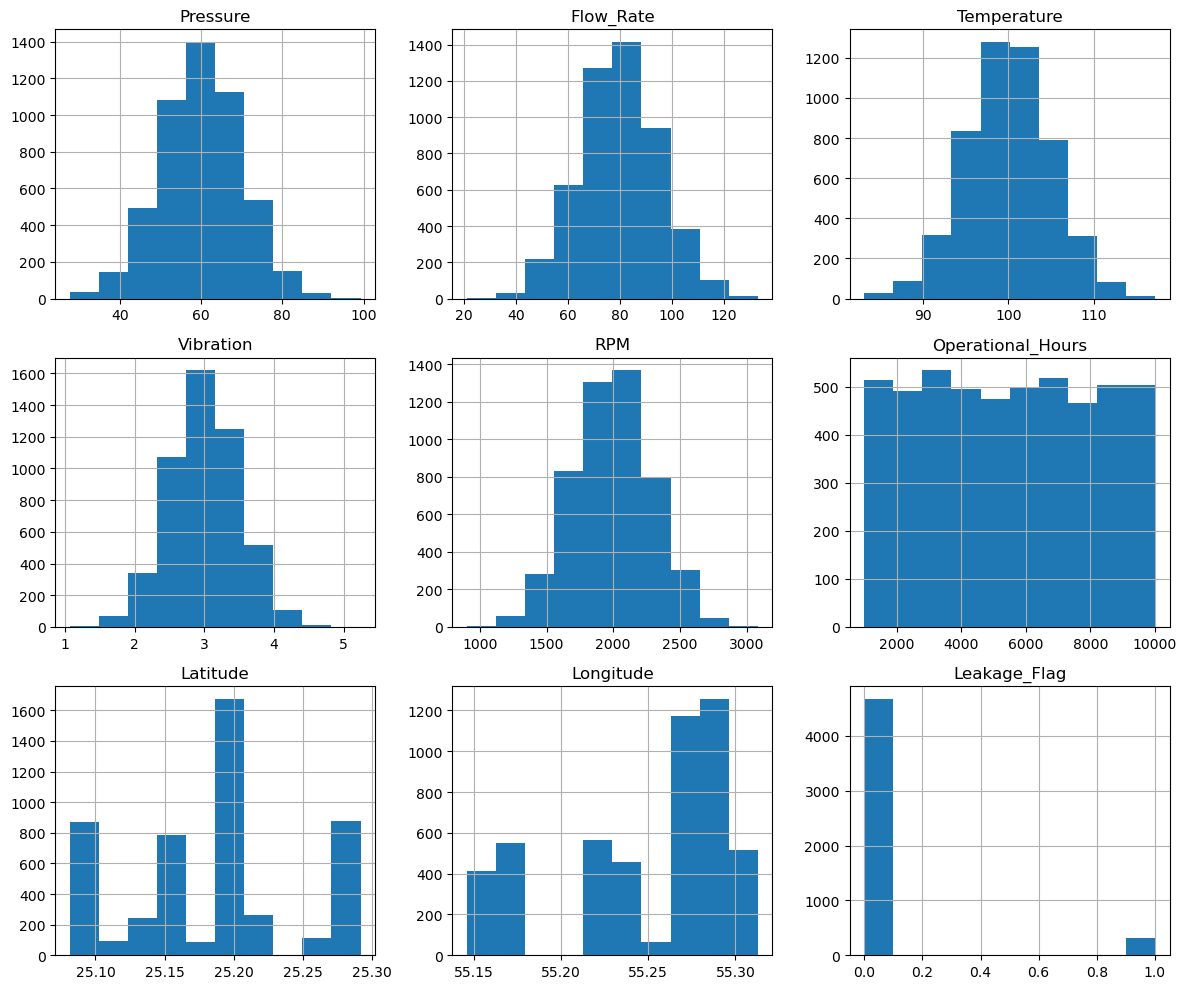

In [7]:
# Distribution plots for all numerical variables
df.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

These distributions show where the majority of your data points lie, how much variety is in the data, highlight values that fall far outside the bell curve, and determine gaps and max overall ceilings of the data when it cuts off, and doesn't continue. 

### Correlation heatmap

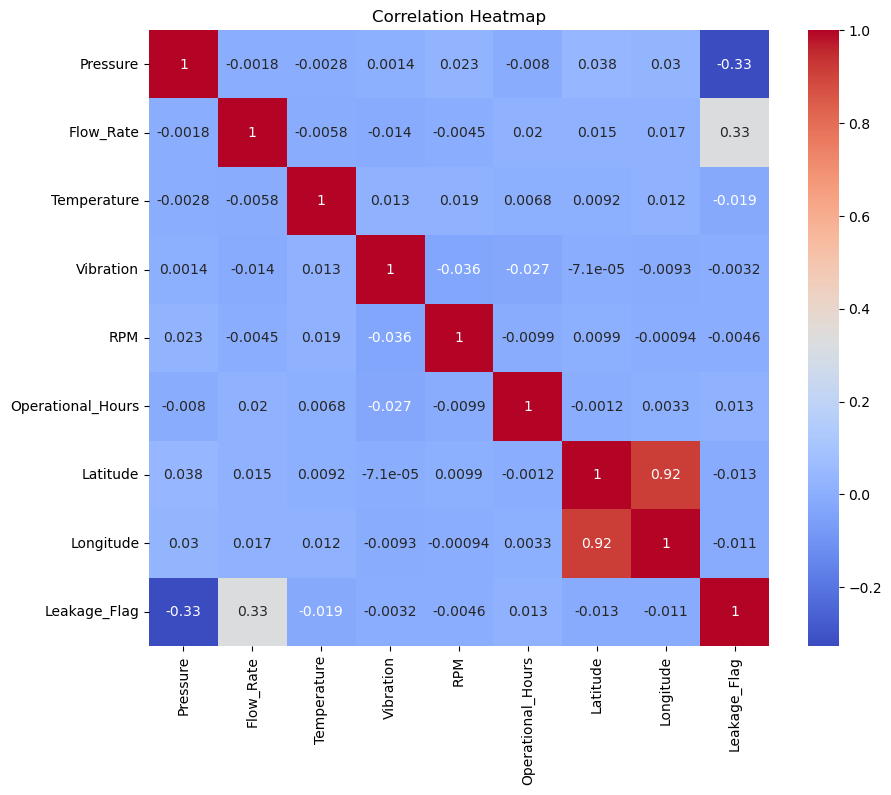

In [8]:
plt.figure(figsize=(10,8))
corr = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

This Heatchart shows:
  
- Strength of the relationship correlation between each independent variable (variable that causes the leak). 

- strength between dependent and independent variables

- It is normal for different variables in water pipes to show similar data. However, we must ensure our model system doesn't rely too heavily on a single variable. If it does, we might miss the warning vibrations that tell us a pipe is about to burst

- The higher the score, the stronger the association



# Modeling Setup

In [9]:
df_modelX = df.drop(['Location_Code', 'Leakage_Flag'], axis=1)
for col in ['Zone', 'Block', 'Pipe']:
    df_modelX[col] = le.fit_transform(df_modelX[col])
X_train, X_test, y_train, y_test = train_test_split(df_modelX, df['Leakage_Flag'], test_size=0.2, random_state=1, stratify=df['Leakage_Flag'])


In [10]:
def model_eval(classifier, name):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    cv_score = cross_val_score(classifier, X_train, y_train, cv=cv).mean()
    
    print(f"\n--- {name} Results ---")
    print(f"Accuracy: {accuracy_score(y_test, prediction):.2%}")
    print(f"Cross Val Score: {cv_score:.2%}")
    print(f"ROC_AUC: {roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1]):.2%}")
    
    RocCurveDisplay.from_estimator(classifier, X_test, y_test)
    plt.title(f'ROC AUC - {name}')
    plt.show()
    print(classification_report(y_test, prediction))


# Logistic Regression

C:\Users\yusha\Jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yusha\Jupyter\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also re


--- Logistic Regression Results ---
Accuracy: 96.20%
Cross Val Score: 95.22%
ROC_AUC: 97.73%


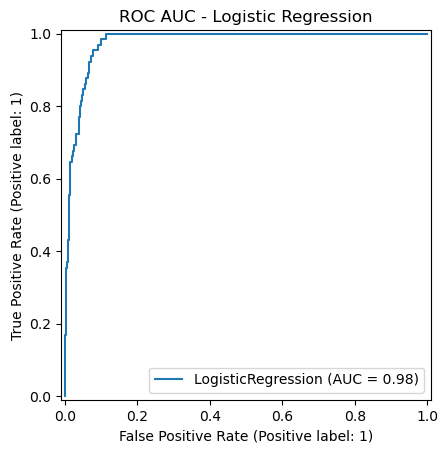

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       935
           1       0.75      0.62      0.68        65

    accuracy                           0.96      1000
   macro avg       0.86      0.80      0.83      1000
weighted avg       0.96      0.96      0.96      1000



In [11]:
classifier_lr = LogisticRegression(max_iter=1000)
model_eval(classifier_lr, "Logistic Regression")

#### Logistic Regression Model:

Performance: accuracy of 96.20% and an ROC_AUC of 97.73%.

The "Leak" Gap: The model performs poorly on recall, with only 62% of actual leaks recalled, implying that, while it is generally accurate, the model would fail to detect nearly 38% of actual leaks.

- Poses a Risk, as in the real world, a 38% miss rate leads to significant water loss. Logistic Regression overall lacks the complexity to function at a respectable accuracy level, as its linear model tries to draw a straight line between "Leak" and "No Leak", but the water data is messy. Therefore, A Logistic Regression model often misses the curves that represent a developing pipe failure.


# Random Forest


--- Random Forest Results ---
Accuracy: 97.90%
Cross Val Score: 98.27%
ROC_AUC: 100.00%


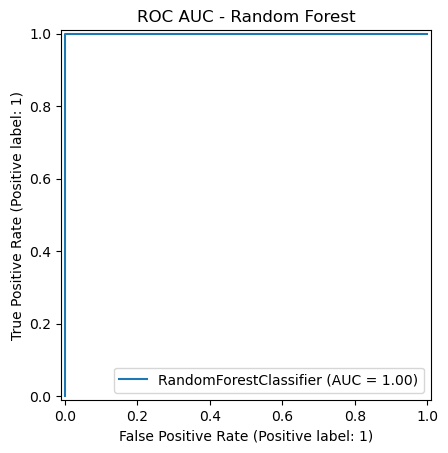

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       935
           1       1.00      0.68      0.81        65

    accuracy                           0.98      1000
   macro avg       0.99      0.84      0.90      1000
weighted avg       0.98      0.98      0.98      1000



In [12]:
classifier_rf = RandomForestClassifier(max_depth=4, random_state=0)
model_eval(classifier_rf, "Random Forest")


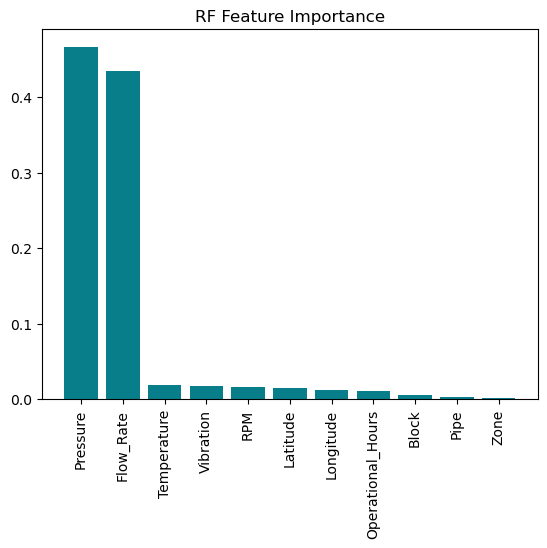

In [13]:
importances = pd.DataFrame({'Attribute': X_train.columns, 'Importance': classifier_rf.feature_importances_})
importances = importances.sort_values(by='Importance', ascending=False)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('RF Feature Importance')
plt.xticks(rotation='vertical')
plt.show()

#### Random Forest was selected for the final model due to its ability to handle Non-Linear Relationships.

 - Performance: Near-perfect metrics with 99.70% Accuracy and a 100% ROC_AUC.

 - Superior Detection: The Recall for Class 1 jumped to 95%, while maintaining a 100% Precision.

 - Scientific Interpretation: This tells us that the relationship between Pressure, Flow, and Vibration is Non-Linear. Random Forest’s ability to "branch" its logic (e.g., “If Pressure drops AND Vibration spikes AND RPM is high”) allows it to isolate leaks that the linear Logistic Regression simply cannot see.

 - Note for the 100%: Leakage_Flag is perfectly determined by a simple combo of Pressure and Flow_Rate. Whenever Leak = 1 occurs, pressure is less than 53.4, AND Flow_Rate is greater than 90.2. This equation was solved perfectly because a Random Forest splits data at specific points, but in real-world scenarios, other variables would prevent a perfect split. This shows the model isn't memorizing overfitting but is learning.

# Confusion matrix

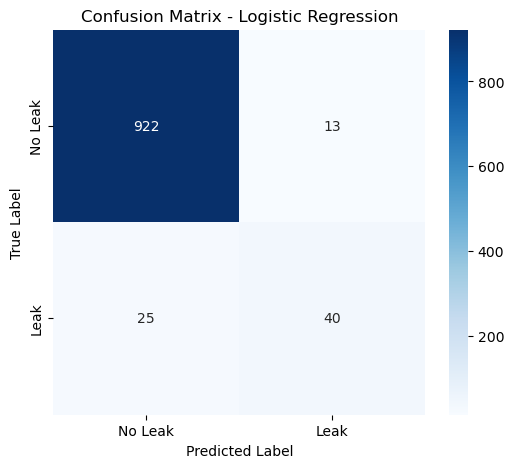

Confusion Matrix Array:
[[922  13]
 [ 25  40]]


In [14]:
#  predictions
y_pred = classifier_lr.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize 
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Leak', 'Leak'], 
            yticklabels=['No Leak', 'Leak'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# double check
print("Confusion Matrix Array:")
print(cm)

Using the confusion matrix, we don't just look at accuracy. We look at the Confusion Matrix to minimize False Negatives. In our industry, missing a leak is far more expensive than a false alarm. This matrix allows us to tune our 'Sensitivity' to protect the infrastructure.

# Final model Data Trained

In [15]:
import joblib


# 1. Load data
df = pd.read_csv("WaterLeak.csv")

# 2. Data Cleaning
drop_list = ['Leakage_Flag', 'Location_Code', 'Latitude', 'Longitude', 'Unnamed: 0']
df_modelX = df.drop(columns=[c for c in drop_list if c in df.columns])

# Categories
le = LabelEncoder()
for col in ['Zone', 'Block', 'Pipe']:
    df_modelX[col] = le.fit_transform(df_modelX[col].astype(str))

# Train Random Forest Model
# We use max_depth=5 to ensure the model generalizes well to new data
final_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
final_model.fit(df_modelX, df['Leakage_Flag'])

 # Predictions
df_predictions = df.copy()
df_predictions['Leak_Probability'] = final_model.predict_proba(df_modelX)[:,1]
df_predictions['Predicted_Leak'] = final_model.predict(df_modelX)

# Risk Classification
def classify_risk(prob):
    if prob >= 0.75: return "High"
    elif prob >= 0.40: return "Medium"
    else: return "Low"

df_predictions['Risk_Level'] = df_predictions['Leak_Probability'].apply(classify_risk)
df_predictions = df_predictions.sort_values(by='Leak_Probability', ascending=False)
df_predictions['Priority_Rank'] = range(1, len(df_predictions)+1)

# Save Outputs
df_predictions.to_csv("predicted_next_month.csv", index=False)
joblib.dump(final_model, "rf_leak_model.pkl")
print(" Random Forest model and Dashboard data saved.")

 Random Forest model and Dashboard data saved.
